<a href="https://colab.research.google.com/github/SeongminCC/Model_for_time_series/blob/main/modeling_2weeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.version)

3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM   # LSTM 층 
from sklearn.model_selection import train_test_split
import random
import os


# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
tf.random.set_seed(19970119)
random.seed(19970119)
np.random.seed(19970119)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DNA/농넷_AIFactory
!ls -al

/content/drive/MyDrive/DNA/농넷_AIFactory
total 9
drwx------ 5 root root 4096 Sep  4 13:59  aT_data
-rw------- 1 root root  370 Sep  4 14:19  lstm.ipynb
drwx------ 4 root root 4096 Sep 17 07:28  tmp_checkpoint.h10
-rw------- 1 root root  118 Sep 16 04:31 '과제 평가지표 종류.txt'


# 학습할 데이터 불러오기

- 전처리가 끝난 데이터를 가져옴
  - 품목 하나에 대해서만 학습

In [ ]:
tr_path = './aT_data/data/train'
ts_path = './aT_data/data/test'


df1 = pd.read_csv(tr_path + '/train_0.csv')
df1_test = pd.read_csv(ts_path + '/set_0/test_0.csv')

**train 데이터**

In [ ]:
df1

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


**Test 데이터**

In [ ]:
df1_test

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%),일자구분_중순,일자구분_초순,월구분_1월
0,20170101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.5,-9.0,-1.0,-12.1,-6.2,0.0,83.6,0,1,1
1,20170102,6243.75,104.0,649649.7,2.0,240001.0,24000101.0,502.0,6246.631731,104.0,...,62.7,-4.7,-1.0,-10.0,-4.9,0.0,52.9,0,1,1
2,20170103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.6,-6.4,-1.0,-11.2,-5.9,0.0,53.0,0,1,1
3,20170104,9009.00,220.0,1978020.0,1.0,230003.0,23000302.0,343.0,5120.897860,1028.0,...,62.5,-8.5,-1.0,-11.5,-6.5,0.0,64.4,0,1,1
4,20170105,10010.00,10.0,99900.0,1.0,230001.0,23000104.0,343.0,8230.493590,156.0,...,56.0,-1.5,-1.2,-9.8,-4.4,0.0,54.6,0,1,1
5,20170106,5494.50,20.0,110110.0,1.0,350301.0,35030102.0,570.0,2910.426210,847.0,...,60.6,-9.4,-1.3,-14.2,-7.5,0.0,58.0,0,1,1
6,20170107,9839.83,23.0,226226.0,2.0,371501.0,37150102.0,730.0,7929.706803,147.0,...,51.2,-8.2,-8.2,-17.1,-13.4,0.0,50.1,0,1,1
7,20170108,2472.47,332.0,820179.0,5.0,230003.0,23000303.0,800.0,2732.702081,817.0,...,50.6,-16.8,-9.3,-20.0,-14.8,0.0,49.3,0,1,1
8,20170109,10510.50,20.0,210210.0,2.0,230001.0,23000104.0,343.0,11539.305556,36.0,...,57.1,-15.5,-7.0,-20.4,-13.5,0.0,56.9,0,1,1
9,20170110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.8,-14.1,-2.3,-18.5,-9.8,0.0,60.3,0,1,1


# nan 제거

- one-hot encoding columns 살리기 위해 결측치 행 제거
- 

**train 데이터 : 결측치 값이 있는 모든 값 제거**

**test 데이터 : 거래가 이루어지지 않은 행 제거 / 중간column에 결측치가 있는 곳은 fillna로 채움**

**train 데이터**

In [ ]:
df2 = df1.dropna()
df2

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
5,20130106,1878.12,40.0,75075.0,2.0,230001.0,23000104.0,800.0,4669.031061,396.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,20161224,10489.50,150.0,1576575.0,1.0,230001.0,23000101.0,323.0,8279.063164,923.0,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


**test 데이터**

In [ ]:
# 단가(원)이 결측치면 행 제거
df2_test = df1_test.dropna(subset = ['단가(원)'])
df2_test['일자별_도매가격_최대(원)']


1          NaN
3     225000.0
4     225000.0
5     225000.0
6     225000.0
7     225000.0
8          NaN
10    225000.0
11    225000.0
12    225000.0
13    225000.0
Name: 일자별_도매가격_최대(원), dtype: float64

In [ ]:
# 결측치 위치 기준 아랫 값 가져오기
df3_test = df2_test.fillna(method='bfill')
df3_test

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%),일자구분_중순,일자구분_초순,월구분_1월
1,20170102,6243.75,104.0,649649.7,2.0,240001.0,24000101.0,502.0,6246.631731,104.0,...,62.7,-4.7,-1.0,-10.0,-4.9,0.0,52.9,0,1,1
3,20170104,9009.00,220.0,1978020.0,1.0,230003.0,23000302.0,343.0,5120.897860,1028.0,...,62.5,-8.5,-1.0,-11.5,-6.5,0.0,64.4,0,1,1
4,20170105,10010.00,10.0,99900.0,1.0,230001.0,23000104.0,343.0,8230.493590,156.0,...,56.0,-1.5,-1.2,-9.8,-4.4,0.0,54.6,0,1,1
5,20170106,5494.50,20.0,110110.0,1.0,350301.0,35030102.0,570.0,2910.426210,847.0,...,60.6,-9.4,-1.3,-14.2,-7.5,0.0,58.0,0,1,1
6,20170107,9839.83,23.0,226226.0,2.0,371501.0,37150102.0,730.0,7929.706803,147.0,...,51.2,-8.2,-8.2,-17.1,-13.4,0.0,50.1,0,1,1
7,20170108,2472.47,332.0,820179.0,5.0,230003.0,23000303.0,800.0,2732.702081,817.0,...,50.6,-16.8,-9.3,-20.0,-14.8,0.0,49.3,0,1,1
8,20170109,10510.50,20.0,210210.0,2.0,230001.0,23000104.0,343.0,11539.305556,36.0,...,57.1,-15.5,-7.0,-20.4,-13.5,0.0,56.9,0,1,1
10,20170111,8991.00,200.0,1801800.0,2.0,230003.0,23000302.0,343.0,4327.612637,1092.0,...,75.4,-7.8,-3.3,-13.1,-8.3,0.0,72.0,1,0,1
11,20170112,1641.64,28.0,45954.0,2.0,320101.0,32010101.0,680.0,7654.905444,349.0,...,80.8,-7.4,1.9,-11.9,-5.4,0.0,80.1,1,0,1
12,20170113,2502.50,88.0,220220.0,1.0,230001.0,23000102.0,800.0,2636.310767,880.0,...,79.2,-2.6,9.4,-6.2,2.1,0.0,81.7,1,0,1


# 2013-01-03 와 같은 형식으로 날짜 재 배열(pd.to_datetime 함수 사용)

**train 데이터**

In [ ]:
date = pd.to_datetime(df2['datadate'], format='%Y%m%d')
df2['datadate'] = date
df2

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
5,2013-01-06,1878.12,40.0,75075.0,2.0,230001.0,23000104.0,800.0,4669.031061,396.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2016-12-24,10489.50,150.0,1576575.0,1.0,230001.0,23000101.0,323.0,8279.063164,923.0,...,1,0,0,0,0,0,0,0,0,0
1457,2016-12-28,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,2016-12-29,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,2016-12-30,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


**test 데이터**

In [ ]:
date_test = pd.to_datetime(df3_test['datadate'], format='%Y%m%d')
df3_test['datadate'] = date_test
df3_test

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%),일자구분_중순,일자구분_초순,월구분_1월
1,2017-01-02,6243.75,104.0,649649.7,2.0,240001.0,24000101.0,502.0,6246.631731,104.0,...,62.7,-4.7,-1.0,-10.0,-4.9,0.0,52.9,0,1,1
3,2017-01-04,9009.00,220.0,1978020.0,1.0,230003.0,23000302.0,343.0,5120.897860,1028.0,...,62.5,-8.5,-1.0,-11.5,-6.5,0.0,64.4,0,1,1
4,2017-01-05,10010.00,10.0,99900.0,1.0,230001.0,23000104.0,343.0,8230.493590,156.0,...,56.0,-1.5,-1.2,-9.8,-4.4,0.0,54.6,0,1,1
5,2017-01-06,5494.50,20.0,110110.0,1.0,350301.0,35030102.0,570.0,2910.426210,847.0,...,60.6,-9.4,-1.3,-14.2,-7.5,0.0,58.0,0,1,1
6,2017-01-07,9839.83,23.0,226226.0,2.0,371501.0,37150102.0,730.0,7929.706803,147.0,...,51.2,-8.2,-8.2,-17.1,-13.4,0.0,50.1,0,1,1
7,2017-01-08,2472.47,332.0,820179.0,5.0,230003.0,23000303.0,800.0,2732.702081,817.0,...,50.6,-16.8,-9.3,-20.0,-14.8,0.0,49.3,0,1,1
8,2017-01-09,10510.50,20.0,210210.0,2.0,230001.0,23000104.0,343.0,11539.305556,36.0,...,57.1,-15.5,-7.0,-20.4,-13.5,0.0,56.9,0,1,1
10,2017-01-11,8991.00,200.0,1801800.0,2.0,230003.0,23000302.0,343.0,4327.612637,1092.0,...,75.4,-7.8,-3.3,-13.1,-8.3,0.0,72.0,1,0,1
11,2017-01-12,1641.64,28.0,45954.0,2.0,320101.0,32010101.0,680.0,7654.905444,349.0,...,80.8,-7.4,1.9,-11.9,-5.4,0.0,80.1,1,0,1
12,2017-01-13,2502.50,88.0,220220.0,1.0,230001.0,23000102.0,800.0,2636.310767,880.0,...,79.2,-2.6,9.4,-6.2,2.1,0.0,81.7,1,0,1


# 데이터프레임 재구성
**0으로 채워져있는 사용할 수 없는 열들 제거**
- X : 27개의 열들
- Y : 해당일자_전체평균가격(원)


*0이 채워져있는 열은 onehotencoding이므로 그대로 살림*

In [ ]:
df3 = df2
df3

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
5,2013-01-06,1878.12,40.0,75075.0,2.0,230001.0,23000104.0,800.0,4669.031061,396.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2016-12-24,10489.50,150.0,1576575.0,1.0,230001.0,23000101.0,323.0,8279.063164,923.0,...,1,0,0,0,0,0,0,0,0,0
1457,2016-12-28,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,2016-12-29,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,2016-12-30,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


# 열 이름 확인
- train과 val으로 나누기 위함

In [ ]:
df3.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)',
       '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)',
       '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순',
       '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
       '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'],
      dtype='object')

# object columns 삭제

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 1 to 1460
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datadate         910 non-null    datetime64[ns]
 1   단가(원)            910 non-null    float64       
 2   거래량              910 non-null    float64       
 3   거래대금(원)          910 non-null    float64       
 4   경매건수             910 non-null    float64       
 5   도매시장코드           910 non-null    float64       
 6   도매법인코드           910 non-null    float64       
 7   산지코드             910 non-null    float64       
 8   해당일자_전체평균가격(원)   910 non-null    float64       
 9   해당일자_전체거래물량(kg)  910 non-null    float64       
 10  하위가격 평균가(원)      910 non-null    float64       
 11  상위가격 평균가(원)      910 non-null    float64       
 12  하위가격 거래물량(kg)    910 non-null    float64       
 13  상위가격 거래물량(kg)    910 non-null    float64       
 14  일자별_도매가격_최대(원)   910 non-null    float64 

In [ ]:
df4 = df3.drop(['주산지_0_습도(%)', '주산지_2_습도(%)', '주산지_2_습도(%)', '주산지_2_습도(%)'], axis=1)
df4

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
5,2013-01-06,1878.12,40.0,75075.0,2.0,230001.0,23000104.0,800.0,4669.031061,396.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2016-12-24,10489.50,150.0,1576575.0,1.0,230001.0,23000101.0,323.0,8279.063164,923.0,...,1,0,0,0,0,0,0,0,0,0
1457,2016-12-28,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,2016-12-29,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,2016-12-30,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 1 to 1460
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datadate         910 non-null    datetime64[ns]
 1   단가(원)            910 non-null    float64       
 2   거래량              910 non-null    float64       
 3   거래대금(원)          910 non-null    float64       
 4   경매건수             910 non-null    float64       
 5   도매시장코드           910 non-null    float64       
 6   도매법인코드           910 non-null    float64       
 7   산지코드             910 non-null    float64       
 8   해당일자_전체평균가격(원)   910 non-null    float64       
 9   해당일자_전체거래물량(kg)  910 non-null    float64       
 10  하위가격 평균가(원)      910 non-null    float64       
 11  상위가격 평균가(원)      910 non-null    float64       
 12  하위가격 거래물량(kg)    910 non-null    float64       
 13  상위가격 거래물량(kg)    910 non-null    float64       
 14  일자별_도매가격_최대(원)   910 non-null    float64 

# 데이터 시각화

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns

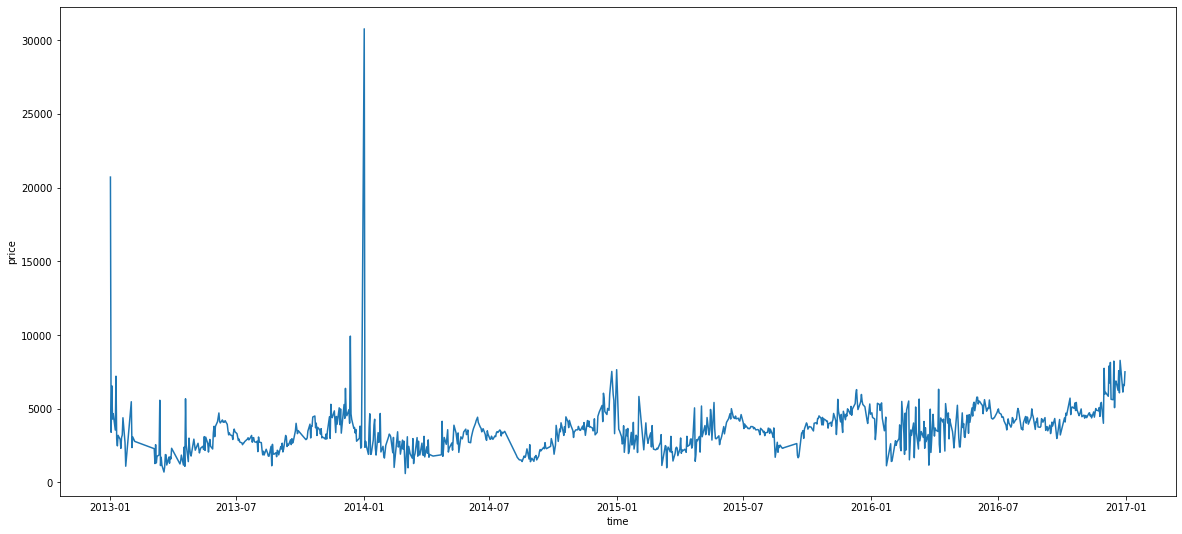

In [ ]:
plt.figure(figsize = (20, 9))
sns.lineplot(x = date, y = df4['해당일자_전체평균가격(원)'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

# Normalization
- 학습이 잘 되도록 데이터를 한번 normalization(정규화) 해준다.

In [ ]:
df4.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_1_초기온도(℃)', '주산지_1_최대온도(℃)',
       '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)', '주산지_1_습도(%)',
       '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_2_강수량(ml)', '일자구분_중순', '일자구분_초순', '일자구분_하순', '월구분_10월', '월구분_11월',
       '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월',
       '월구분_7월', '월구분_8월', '월구분_9월'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_1_초기온도(℃)', '주산지_1_최대온도(℃)',
       '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)', '주산지_1_습도(%)',
       '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_2_강수량(ml)', '일자구분_중순', '일자구분_초순', '일자구분_하순', '월구분_10월', '월구분_11월',
       '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월',
       '월구분_7월', '월구분_8월', '월구분_9월']
                    
df_scaled = scaler.fit_transform(df3[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,0.126323,0.000212,0.001130,0.000000,0.967086,0.967086,0.717647,0.666614,0.000117,0.663235,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.035635,0.009960,0.010118,0.000000,0.443787,0.443787,0.788235,0.092780,0.015270,0.262538,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.176403,0.025217,0.115962,0.083333,0.443787,0.443787,0.227059,0.197269,0.007620,0.303048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.071057,0.114219,0.218856,0.125000,0.967086,0.967086,0.720000,0.122522,0.035473,0.397916,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035208,0.008264,0.008290,0.041667,0.443787,0.443787,0.788235,0.134786,0.011036,0.291673,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0.219144,0.031574,0.179560,0.000000,0.443787,0.443787,0.227059,0.254458,0.026423,0.791805,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
906,0.053890,0.012503,0.018528,0.125000,0.443787,0.443787,0.788235,0.183179,0.046042,0.357081,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907,0.208902,0.003602,0.020278,0.000000,0.443794,0.443794,0.111765,0.200257,0.012233,0.559923,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,0.238836,0.000636,0.004933,0.000000,0.888683,0.888683,0.517647,0.197885,0.027853,0.521241,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 데이터셋 생성

In [ ]:
TEST_SIZE = 14  # 2주간 데이터 예측

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=4):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체거래물량(kg)',
                '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
                '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
                '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
                '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)']
label_cols = ['해당일자_전체평균가격(원)']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((1154, 4, 26), (289, 4, 26))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label)
test_feature.shape, test_label.shape
# ((10, 4, 26), (10, 1))

((10, 4, 26), (10, 1))

# LSTM 모델 생성

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow.keras import optimizers



model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False))
model.add(Dense(1))

In [ ]:
model_path = '/content/drive/MyDrive/DNA/농넷_AIFactory'


model.compile(loss='mean_squared_error', 
              optimizer=optimizers.Adam(lr=1e-4, 
                                        beta_1=0.9, 
                                        beta_2=0.999, 
                                        decay=1e-6))



early_stop = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                           patience=10)   # 10회 Epoch동안 개선되지 않는다면 종료


filename = os.path.join(model_path, 'tmp_checkpoint.h10')

checkpoint = ModelCheckpoint(filename,  # 파일명 지정
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출
                             verbose=1,  # 로그를 출력
                             save_best_only=True,   # 가장 best 값만 저장
                             mode='auto')     # auto는 알아서 best를 찾는다. min/max


history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0839
Epoch 1: val_loss improved from inf to 0.06838, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 14s 54ms/step - loss: 0.0836 - val_loss: 0.0684
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 0.0443
Epoch 2: val_loss improved from 0.06838 to 0.03715, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0443 - val_loss: 0.0371
Epoch 3/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0229
Epoch 3: val_loss improved from 0.03715 to 0.02106, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0237 - val_loss: 0.0211
Epoch 4/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0145
Epoch 4: val_loss improved from 0.02106 to 0.01375, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 56ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 5/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0105
Epoch 5: val_loss improved from 0.01375 to 0.01087, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 6/200
45/45 [==============================] - ETA: 0s - loss: 0.0091
Epoch 6: val_loss improved from 0.01087 to 0.00930, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 47ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 7/200
44/45 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 7: val_loss improved from 0.00930 to 0.00813, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 62ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 8/200
32/45 [====================>.........] - ETA: 0s - loss: 0.0078
Epoch 8: val_loss improved from 0.00813 to 0.00714, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0070
Epoch 9: val_loss improved from 0.00714 to 0.00613, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/200
44/45 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 10: val_loss improved from 0.00613 to 0.00530, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 11/200
45/45 [==============================] - ETA: 0s - loss: 0.0052
Epoch 11: val_loss improved from 0.00530 to 0.00457, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 61ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 12/200
44/45 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 12: val_loss improved from 0.00457 to 0.00398, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 13/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0043
Epoch 13: val_loss improved from 0.00398 to 0.00352, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 14/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0041
Epoch 14: val_loss improved from 0.00352 to 0.00317, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 15/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0039
Epoch 15: val_loss improved from 0.00317 to 0.00286, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 4s 79ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 16/200
44/45 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 16: val_loss improved from 0.00286 to 0.00263, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 4s 83ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 17/200
30/45 [===================>..........] - ETA: 0s - loss: 0.0020
Epoch 17: val_loss improved from 0.00263 to 0.00249, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 18/200
45/45 [==============================] - ETA: 0s - loss: 0.0032
Epoch 18: val_loss improved from 0.00249 to 0.00232, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 67ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 19/200
34/45 [=====================>........] - ETA: 0s - loss: 0.0019
Epoch 19: val_loss improved from 0.00232 to 0.00222, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 4s 91ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 20/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0032
Epoch 20: val_loss improved from 0.00222 to 0.00213, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 65ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 21/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0030
Epoch 21: val_loss improved from 0.00213 to 0.00203, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 22/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0031
Epoch 22: val_loss improved from 0.00203 to 0.00199, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 23/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0030
Epoch 23: val_loss improved from 0.00199 to 0.00191, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 63ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 24/200
44/45 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 24: val_loss improved from 0.00191 to 0.00186, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 25/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0028
Epoch 25: val_loss improved from 0.00186 to 0.00181, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 26/200
32/45 [====================>.........] - ETA: 0s - loss: 0.0031
Epoch 26: val_loss improved from 0.00181 to 0.00178, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 27/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0030
Epoch 27: val_loss improved from 0.00178 to 0.00169, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 65ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 28/200
31/45 [===================>..........] - ETA: 0s - loss: 0.0033
Epoch 28: val_loss improved from 0.00169 to 0.00166, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 29/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0026
Epoch 29: val_loss improved from 0.00166 to 0.00165, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 30/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0027
Epoch 30: val_loss improved from 0.00165 to 0.00161, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 31/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0027
Epoch 31: val_loss improved from 0.00161 to 0.00157, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 62ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 32/200
32/45 [====================>.........] - ETA: 0s - loss: 0.0030
Epoch 32: val_loss improved from 0.00157 to 0.00155, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 33/200
44/45 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 33: val_loss improved from 0.00155 to 0.00154, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 34/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 34: val_loss improved from 0.00154 to 0.00151, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 35/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0026
Epoch 35: val_loss did not improve from 0.00151
45/45 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 36/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 36: val_loss improved from 0.00151 to 0.00146, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 61ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 37/200
33/45 [=====================>........] - ETA: 0s - loss: 0.0028
Epoch 37: val_loss improved from 0.00146 to 0.00145, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 38/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0025
Epoch 38: val_loss improved from 0.00145 to 0.00144, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 39/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 39: val_loss improved from 0.00144 to 0.00143, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 40/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 40: val_loss improved from 0.00143 to 0.00142, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 63ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 41/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0026
Epoch 41: val_loss improved from 0.00142 to 0.00140, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 47ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 42/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 42: val_loss did not improve from 0.00140
45/45 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 43/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 43: val_loss improved from 0.00140 to 0.00138, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 44/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 44: val_loss improved from 0.00138 to 0.00136, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 63ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 45/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 45: val_loss improved from 0.00136 to 0.00135, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 46/200
44/45 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 46: val_loss improved from 0.00135 to 0.00133, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 47/200
44/45 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 47: val_loss improved from 0.00133 to 0.00129, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 48/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0024
Epoch 48: val_loss improved from 0.00129 to 0.00128, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 64ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 49/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 49: val_loss did not improve from 0.00128
45/45 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 50/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 50: val_loss improved from 0.00128 to 0.00127, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 51/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0024
Epoch 51: val_loss improved from 0.00127 to 0.00125, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 74ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 52/200
45/45 [==============================] - ETA: 0s - loss: 0.0022
Epoch 52: val_loss improved from 0.00125 to 0.00124, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 53/200
45/45 [==============================] - ETA: 0s - loss: 0.0022
Epoch 53: val_loss improved from 0.00124 to 0.00124, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 66ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 54/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0010
Epoch 54: val_loss improved from 0.00124 to 0.00123, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 55/200
44/45 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 55: val_loss improved from 0.00123 to 0.00121, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 56/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 56: val_loss improved from 0.00121 to 0.00120, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 57/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 57: val_loss improved from 0.00120 to 0.00118, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 64ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 58/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 58: val_loss did not improve from 0.00118
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 59/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0024
Epoch 59: val_loss did not improve from 0.00118
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 60/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 60: val_loss improved from 0.00118 to 0.00117, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 61/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0023    
Epoch 61: val_loss improved from 0.00117 to 0.00114, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 62/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 62: val_loss did not improve from 0.00114
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 63/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 63: val_loss improved from 0.00114 to 0.00113, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 64/200
41/45 [==========================>...] - ETA: 0s - loss: 9.3429e-04
Epoch 64: val_loss did not improve from 0.00113
45/45 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 65/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 65: val_loss improved from 0.00113 to 0.00110, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 60ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 66/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 66: val_loss did not improve from 0.00110
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 67/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 67: val_loss did not improve from 0.00110
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 68/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0022    
Epoch 68: val_loss improved from 0.00110 to 0.00108, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 52ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 69/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 69: val_loss did not improve from 0.00108
45/45 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 70/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 70: val_loss did not improve from 0.00108
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 71/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 71: val_loss did not improve from 0.00108
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 72/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0022
Epoch 72: val_loss improved from 0.00108 to 0.00107, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 73/200
44/45 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 73: val_loss did not improve from 0.00107
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 74/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0022
Epoch 74: val_loss improved from 0.00107 to 0.00105, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 75/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0022    
Epoch 75: val_loss improved from 0.00105 to 0.00105, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 64ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 76/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 76: val_loss improved from 0.00105 to 0.00103, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 77/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 77: val_loss did not improve from 0.00103
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 78/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0022    
Epoch 78: val_loss improved from 0.00103 to 0.00101, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 79/200
44/45 [============================>.] - ETA: 0s - loss: 0.0020    
Epoch 79: val_loss improved from 0.00101 to 0.00101, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 57ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 80/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0020    
Epoch 80: val_loss did not improve from 0.00101
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 81/200
44/45 [============================>.] - ETA: 0s - loss: 0.0020    
Epoch 81: val_loss did not improve from 0.00101
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 82/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 82: val_loss did not improve from 0.00101
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 83/200
44/45 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 83: val_loss did not improve from 0.00101
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 84/200
37/45 [=======================>......] - ET

45/45 [==============================] - 2s 51ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 85/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0021
Epoch 85: val_loss improved from 0.00100 to 0.00098, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0019 - val_loss: 9.8210e-04
Epoch 86/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 86: val_loss did not improve from 0.00098
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 87/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0020
Epoch 87: val_loss did not improve from 0.00098
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 88/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0021    
Epoch 88: val_loss improved from 0.00098 to 0.00098, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 9.8008e-04
Epoch 89/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0021    
Epoch 89: val_loss did not improve from 0.00098
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.8684e-04
Epoch 90/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0022
Epoch 90: val_loss improved from 0.00098 to 0.00098, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 66ms/step - loss: 0.0019 - val_loss: 9.7848e-04
Epoch 91/200
36/45 [=======================>......] - ETA: 0s - loss: 8.7651e-04
Epoch 91: val_loss improved from 0.00098 to 0.00095, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 9.5367e-04
Epoch 92/200
36/45 [=======================>......] - ETA: 0s - loss: 0.0022
Epoch 92: val_loss did not improve from 0.00095
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.7335e-04
Epoch 93/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0020    
Epoch 93: val_loss improved from 0.00095 to 0.00095, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0019 - val_loss: 9.4990e-04
Epoch 94/200
33/45 [=====================>........] - ETA: 0s - loss: 0.0023    
Epoch 94: val_loss did not improve from 0.00095
45/45 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 9.8622e-04
Epoch 95/200
44/45 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 95: val_loss did not improve from 0.00095
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.7004e-04
Epoch 96/200
35/45 [======================>.......] - ETA: 0s - loss: 0.0022
Epoch 96: val_loss did not improve from 0.00095
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.7771e-04
Epoch 97/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 97: val_loss did not improve from 0.00095
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.6703e-04
Epoch 98/200
43/45 [====================

45/45 [==============================] - 2s 49ms/step - loss: 0.0019 - val_loss: 9.3377e-04
Epoch 101/200
44/45 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 101: val_loss did not improve from 0.00093
45/45 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 9.6093e-04
Epoch 102/200
37/45 [=======================>......] - ETA: 0s - loss: 8.2180e-04
Epoch 102: val_loss improved from 0.00093 to 0.00092, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 66ms/step - loss: 0.0019 - val_loss: 9.2038e-04
Epoch 103/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 103: val_loss did not improve from 0.00092
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.4777e-04
Epoch 104/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 104: val_loss did not improve from 0.00092
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.2710e-04
Epoch 105/200
45/45 [==============================] - ETA: 0s - loss: 0.0019
Epoch 105: val_loss did not improve from 0.00092
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.4261e-04
Epoch 106/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 106: val_loss did not improve from 0.00092
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.3889e-04
Epoch 107/200
41/45 [===========

45/45 [==============================] - 2s 47ms/step - loss: 0.0019 - val_loss: 9.1851e-04
Epoch 109/200
30/45 [===================>..........] - ETA: 0s - loss: 7.7965e-04
Epoch 109: val_loss improved from 0.00092 to 0.00091, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0019 - val_loss: 9.1370e-04
Epoch 110/200
45/45 [==============================] - ETA: 0s - loss: 0.0019
Epoch 110: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.2792e-04
Epoch 111/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0019
Epoch 111: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.6760e-04
Epoch 112/200
30/45 [===================>..........] - ETA: 0s - loss: 8.8388e-04
Epoch 112: val_loss improved from 0.00091 to 0.00091, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 9.1070e-04
Epoch 113/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0020
Epoch 113: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 9.1593e-04
Epoch 114/200
31/45 [===================>..........] - ETA: 0s - loss: 0.0023
Epoch 114: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 9.6142e-04
Epoch 115/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0019
Epoch 115: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.7652e-04
Epoch 116/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0019
Epoch 116: val_loss did not improve from 0.00091
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 9.3803e-04
Epoch 117/200
36/45 [===============

45/45 [==============================] - 3s 60ms/step - loss: 0.0018 - val_loss: 9.1020e-04
Epoch 118/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 118: val_loss improved from 0.00091 to 0.00090, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 48ms/step - loss: 0.0018 - val_loss: 8.9891e-04
Epoch 119/200
30/45 [===================>..........] - ETA: 0s - loss: 0.0023
Epoch 119: val_loss did not improve from 0.00090
45/45 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 9.4665e-04
Epoch 120/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0019    
Epoch 120: val_loss improved from 0.00090 to 0.00090, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0018 - val_loss: 8.9860e-04
Epoch 121/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0020    
Epoch 121: val_loss did not improve from 0.00090
45/45 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 9.2344e-04
Epoch 122/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 122: val_loss improved from 0.00090 to 0.00090, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 50ms/step - loss: 0.0018 - val_loss: 8.9517e-04
Epoch 123/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 123: val_loss did not improve from 0.00090
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.9571e-04
Epoch 124/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 124: val_loss improved from 0.00090 to 0.00089, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 8.8845e-04
Epoch 125/200
39/45 [=========================>....] - ETA: 0s - loss: 8.0742e-04
Epoch 125: val_loss did not improve from 0.00089
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.0306e-04
Epoch 126/200
33/45 [=====================>........] - ETA: 0s - loss: 0.0022    
Epoch 126: val_loss did not improve from 0.00089
45/45 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 8.9313e-04
Epoch 127/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 127: val_loss did not improve from 0.00089
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.9135e-04
Epoch 128/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0020
Epoch 128: val_loss did not improve from 0.00089
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.9041e-04
Epoch 129/200
41/45 [===

45/45 [==============================] - 2s 50ms/step - loss: 0.0018 - val_loss: 8.8186e-04
Epoch 130/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 130: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.4574e-04
Epoch 131/200
31/45 [===================>..........] - ETA: 0s - loss: 0.0023    
Epoch 131: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.9708e-04
Epoch 132/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0021    
Epoch 132: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.0046e-04
Epoch 133/200
34/45 [=====================>........] - ETA: 0s - loss: 0.0021    
Epoch 133: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.4921e-04
Epoch 134/200
38/45 [===

45/45 [==============================] - 2s 49ms/step - loss: 0.0018 - val_loss: 8.7864e-04
Epoch 136/200
44/45 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 136: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.0311e-04
Epoch 137/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 137: val_loss improved from 0.00088 to 0.00088, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


45/45 [==============================] - 2s 49ms/step - loss: 0.0018 - val_loss: 8.7552e-04
Epoch 138/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0019
Epoch 138: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 9.0866e-04
Epoch 139/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0019    
Epoch 139: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.7716e-04
Epoch 140/200
33/45 [=====================>........] - ETA: 0s - loss: 7.2924e-04
Epoch 140: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 8.7898e-04
Epoch 141/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0019    
Epoch 141: val_loss did not improve from 0.00088
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 8.7828e-04
Epoch 142/200
38/45 [===

**val_loss : 0.00088**

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_feature)

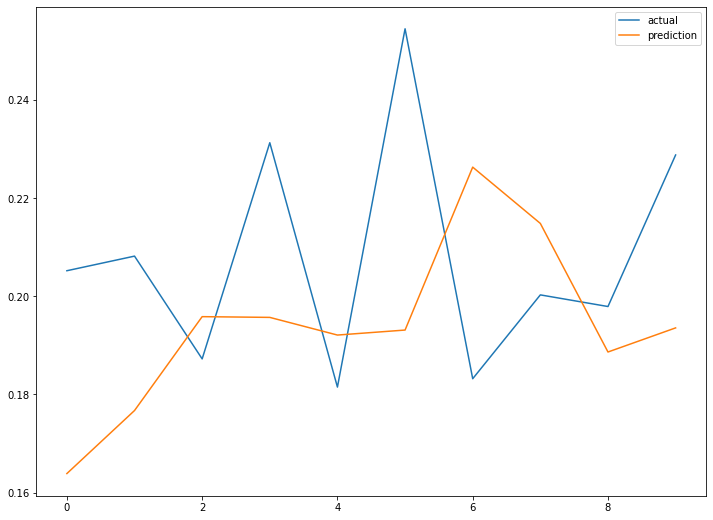

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 랜덤 포레스트(Random forest)
- 의사결정 트리를 랜덤하게 나온 것을 투표하여 결정하는 것 
  - 분류, 회귀에 주로 사용된다 



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

In [ ]:
clf = RandomForestRegressor()

In [ ]:
# 위에서 만든 데이터셋

# x_train, y_train   : train
# x_valid, y_valid   : validation
# test_feature, test_label   : test

In [ ]:
# X = df_scaled.drop(columns='해당일자_전체평균가격(원)') # '해당일자_전체평균가격(원)' column 제외
# y = df_scaled['해당일자_전체평균가격(원)']  # '해당일자_전체평균가격(원)' 예측

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(1095,)


In [ ]:
test_size = 14
X_train = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[:-test_size]
y_train = df_scaled['해당일자_전체평균가격(원)'].iloc[:-test_size]

X_test = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[-test_size:]
y_test = df_scaled['해당일자_전체평균가격(원)'].iloc[-test_size:]

In [ ]:
clf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

0.0005796460306035417

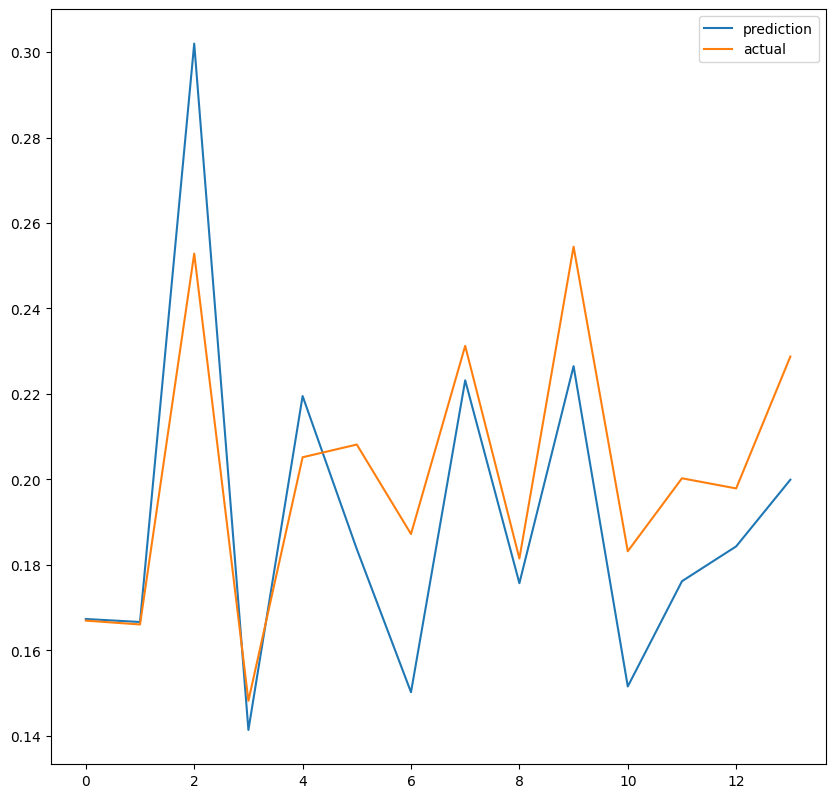

In [ ]:
y_test.index = range(14)

fig = plt.figure(figsize = (10, 10), dpi = 100)
ax = fig.subplots()

ax.plot(y_pred, label = 'prediction')
ax.plot(y_test, label = 'actual')
ax.legend()


val_loss : 0.0005796460306035417

# Prophet

In [ ]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet

     |████████████████████████████████| 67.3 MB 97 kB/s 
     |████████████████████████████████| 64 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
from fbprophet import Prophet

In [ ]:
da = date.tolist()
print(date)

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1456   2016-12-27
1457   2016-12-28
1458   2016-12-29
1459   2016-12-30
1460   2016-12-31
Name: datadate, Length: 1461, dtype: datetime64[ns]


In [ ]:
df = pd.DataFrame(data=[da, df_scaled['해당일자_전체평균가격(원)']]).T
df.columns = ['ds', 'y']
df.index = da

In [ ]:
df

,ds,y
2013-01-01,2013-01-01,0.666642
2013-01-02,2013-01-02,0.666642
2013-01-03,2013-01-03,0.092854
2013-01-04,2013-01-04,0.197334
2013-01-05,2013-01-05,0.122594
...,...,...
2016-12-27,2016-12-27,0.183245
2016-12-28,2016-12-28,0.183245
2016-12-29,2016-12-29,0.200322
2016-12-30,2016-12-30,0.19795


In [ ]:
val_size = 14

df_train = df.iloc[:-val_size]
df_val = df.iloc[-val_size:]

df_train

,ds,y
2013-01-01,2013-01-01,0.666642
2013-01-02,2013-01-02,0.666642
2013-01-03,2013-01-03,0.092854
2013-01-04,2013-01-04,0.197334
2013-01-05,2013-01-05,0.122594
...,...,...
2016-12-13,2016-12-13,0.166111
2016-12-14,2016-12-14,0.166111
2016-12-15,2016-12-15,0.252907
2016-12-16,2016-12-16,0.148238


In [ ]:
m = Prophet()  #프로펫 변수설정

m.fit(df_train) #프로펫을 학습시킨다.

future=m.make_future_dataframe(periods=14)  # 14일치를 예측할 것.

forecast=m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**훈련용 데이터 시각화**

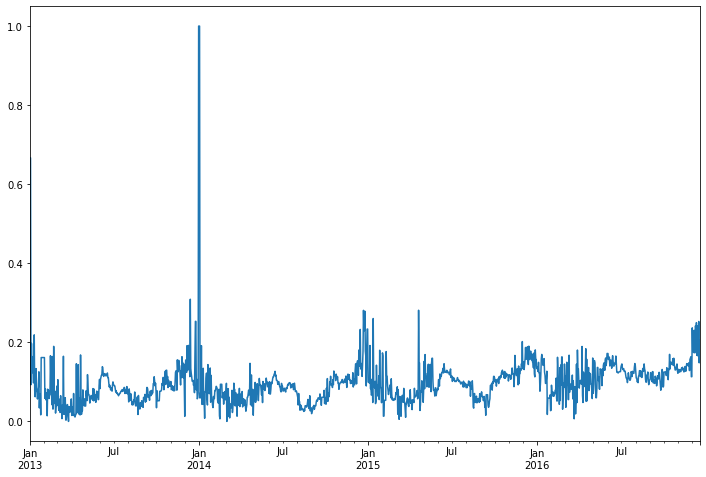

In [ ]:
ax = df_train['y'].plot(figsize=(12,8))
plt.show()

**예측 결과 확인**

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,0.204798,0.139229,0.270199
1,2013-01-02,0.200996,0.136914,0.268139
2,2013-01-03,0.191727,0.126125,0.255696
3,2013-01-04,0.182470,0.121577,0.246512
4,2013-01-05,0.175068,0.103710,0.241317
...,...,...,...,...
1456,2016-12-27,0.249723,0.183572,0.317566
1457,2016-12-28,0.249541,0.176942,0.312618
1458,2016-12-29,0.243815,0.180703,0.313739
1459,2016-12-30,0.237967,0.175339,0.305621


**예측값 시각화**

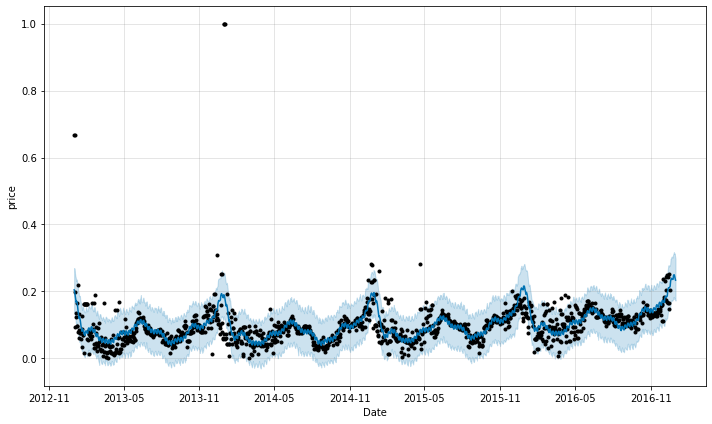

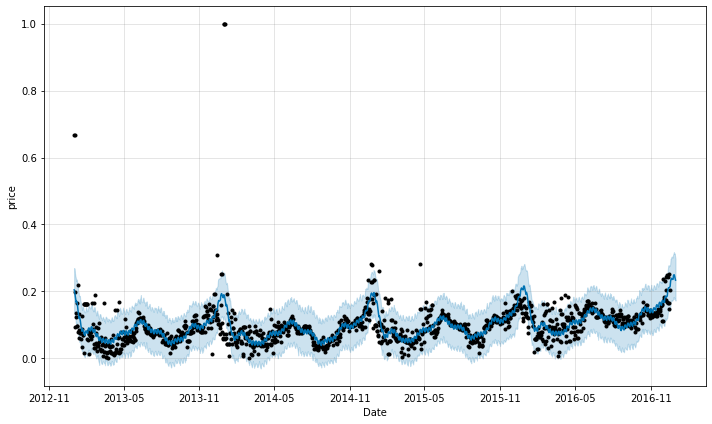

In [ ]:
m.plot(forecast, xlabel='Date', ylabel='price')

In [ ]:
y_pred = forecast['yhat'][-14:]
y_val = df_val['y']
mean_squared_error(y_pred, y_val)

0.0018623818329433414

val_loss : 0.0018623818329433414


# LGBM

# Result(MSE)
1. LSTM : 0.00290
2. Random Forest : 0.0008831665401987361
3. Prophet : 0.0018623818329433414
